In [1]:
import pandas as pd
import html
import re


In [11]:
folder = "/Users/basileroth/Desktop/Code/offseason_greenlobby/data/raw/AMO20_dep_sen_min_tous_mandats_et_organes_XVII-master/organes/"
folder_acteurs = "/Users/basileroth/Desktop/Code/offseason_greenlobby/data/raw/AMO20_dep_sen_min_tous_mandats_et_organes_XVII-master/acteurs/"

import json

def get_gp(folder,gp):

    with open(folder + gp + '.json') as f:
        d = json.load(f)
        return d['libelleAbrege']
    
def get_gp_nom(folder,gp):

    with open(folder + gp + '.json') as f:
        d = json.load(f)
        return d['libelle']
    

def get_id_nom(folder,acteur):
    with open(folder + acteur + '.json') as f:
        d = json.load(f)
        return d['etatCivil']['ident']['nom']
    
def get_id_prenom(folder,acteur):
    with open(folder + acteur + '.json') as f:
        d = json.load(f)
        return d['etatCivil']['ident']['prenom']
            

def clean_text(text):
    """ Nettoie le texte HTML pour le rendre plus lisible pour un humain. """
    decoded_text = html.unescape(text)
    clean_text = re.sub(r'<[^>]*>', '', decoded_text)
    clean_text = clean_text.replace('«', '"').replace('»', '"')
    clean_text = clean_text.replace(u'\xa0', ' ')
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()
    return clean_text

import re

def cleaned_text(text):
    first = re.sub(r'[^\w\s]+', '', text)
    cleaned_text = re.sub(r'\s+', ' ', first).strip()
    return cleaned_text

In [12]:
from sentence_transformers import SentenceTransformer, util

# Charger un modèle multilingue
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

In [13]:
def article_match(article_courte, target_article):
    """Retourne True si article_courte correspond à l'article voulu, même s'il y a des zéros ou du texte autour."""
    pattern = rf'\b0*{re.escape(str(target_article))}\b'
    return bool(re.search(pattern, article_courte))

# Charger les données

In [ ]:
df_amendements = pd.read_csv("/Users/basileroth/Desktop/Code/offseason_greenlobby/data/processed/amendements_duplomb.csv")
df_amendements["groupe_politique"] = df_amendements["groupePolitiqueRef"].apply(lambda x : get_gp(folder,x) if len(x) == 8 else "Inconnu")
df_amendements["groupe_politique_nom"] = df_amendements["groupePolitiqueRef"].apply(lambda x : get_gp_nom(folder,x) if len(x) == 8 else "Inconnu")
df_amendements["article"] = df_amendements["article_courte"].apply(lambda x : re.findall(r'\d+', x)[0] if len(re.findall(r'\d+', x))> 0 else 1)

df_amendements["nom"] = df_amendements["acteurRef"].apply(lambda x : get_id_prenom(folder_acteurs,x) if len(x) == 8 else "Inconnu")
df_amendements["prenom"] = df_amendements["acteurRef"].apply(lambda x : get_id_nom(folder_acteurs,x) if len(x) == 8 else "Inconnu")

df_amendements = df_amendements[df_amendements.type == "AN"]
partis_exclure = ["LFI-NFP","EcoS"]
df_amendements = df_amendements[~df_amendements.groupe_politique.isin(partis_exclure)]

In [16]:
parti_couleurs = {
    'La France insoumise - Nouveau Front Populaire': 'red',
    'Écologiste et Social': 'green',
    'Libertés, Indépendants, Outre-mer et Territoires': 'orange',
    'Ensemble pour la République': 'orange',
    'Socialistes et apparentés': 'red',
    'Droite Républicaine': 'blue',
    'Rassemblement National': 'darkblue',
    'Les Démocrates': 'orange',
    'Gauche Démocrate et Républicaine': 'red',
    'Horizons & Indépendants': 'lightblue',
    'UDR': 'blue',
    'Non inscrit': 'grey',
    'Inconnu': 'grey'
}

In [17]:
dict_groups = df_amendements[["groupe_politique","groupe_politique_nom"]].drop_duplicates().reset_index(drop=True).set_index("groupe_politique").to_dict()

In [18]:
NUM = 9
NOM_COL = "article"
tickers = df_amendements[NOM_COL].value_counts()[:NUM].index

/var/folders/nr/fcv36l313kg3rwgbxhwbjhz00000gn/T/ipykernel_34518/2782840924.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
/var/folders/nr/fcv36l313kg3rwgbxhwbjhz00000gn/T/ipykernel_34518/2782840924.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
/var/folders/nr/fcv36l313kg3rwgbxhwbjhz00000gn/T/ipykernel_34518/2782840924.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
/var/folders/nr/fcv36l313kg3rwgbxhwbjhz00000gn/T/ipykernel_34518/2782840924.py:20: UserWarning: set_ticklabels() should only be used 

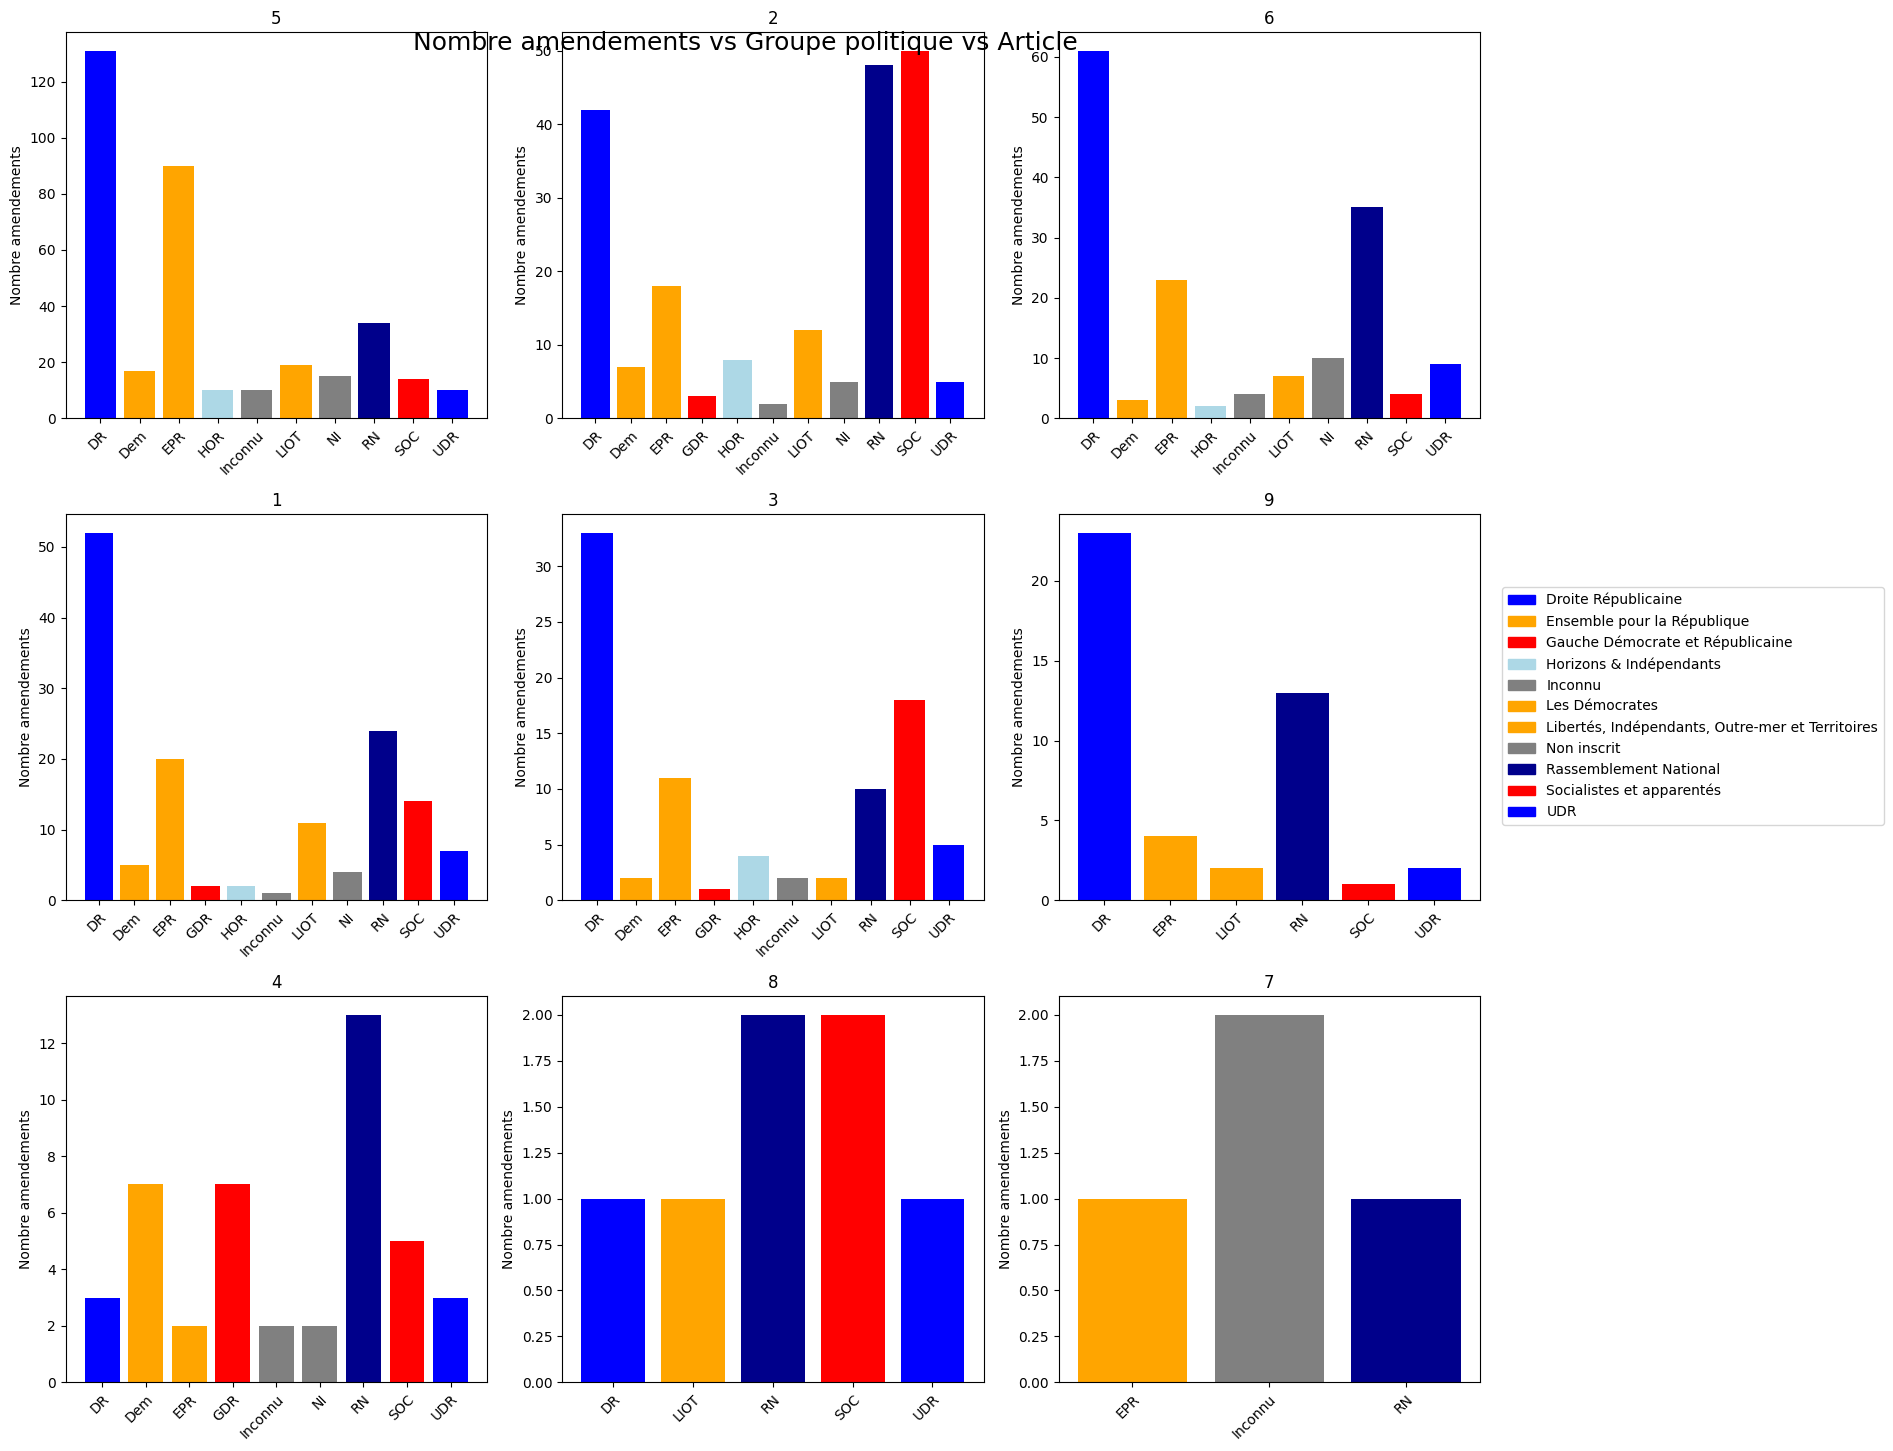

In [19]:
# define subplot grid
import matplotlib.pyplot as plt 

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

plt.subplots_adjust(hspace=0.5)

# loop through tickers and axes
for ticker, ax in zip(tickers, axs.ravel()):
    # filter df for ticker and plot on specified axes
    sub = df_amendements[df_amendements[NOM_COL] == ticker].groupby("groupe_politique").ExposeSommaire.count()
    values = sub.values
    labels = sub.index

    colors = [parti_couleurs.get(dict_groups['groupe_politique_nom'][party], 'grey') for party in labels]

    bars = ax.bar(labels, values, color=colors)
    ax.set_title(ticker)
    ax.set_ylabel("Nombre amendements")
    ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')


sub = df_amendements.groupby("groupe_politique_nom").ExposeSommaire.count()
labels = sub.index
colors = [parti_couleurs.get(party, 'grey') for party in labels]

handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("output.png");
plt.suptitle("Nombre amendements vs Groupe politique vs Article", fontsize=18, y=0.95);
fig.tight_layout()
plt.show();

# FNSEA

In [26]:
df_amendements["contains_FNSEA"] = df_amendements["ExposeSommaire"].apply(lambda x : True if ("FNSEA" in x) or ("fnsea" in x) or ("Fédération Nationale des Syndicats d'Exploitants Agricoles et les Jeunes Agriculteurs" in x)else False)

In [27]:
df_amendements[df_amendements["contains_FNSEA"] == True].to_excel("amendements_recherche_fnsea.xlsx")

In [28]:
df_amendements[df_amendements["contains_FNSEA"] == True].groupe_politique_nom.value_counts()

groupe_politique_nom
Ensemble pour la République                         51
Droite Républicaine                                 35
Libertés, Indépendants, Outre-mer et Territoires    26
Rassemblement National                               4
Name: count, dtype: int64

In [29]:
df_amendements["contains_FNSEA"].value_counts()

contains_FNSEA
False    922
True     116
Name: count, dtype: int64

# Regarder si les amendements sont repris mots pour mots par les différents partis

In [43]:
df_fnsea = pd.read_excel("/Users/basileroth/Desktop/Code/offseason_greenlobby/data/raw/Amendements_FNSEA_PROPAL.xlsx")
df_fnsea.head()

df_fnsea = df_fnsea[df_fnsea["Modification proposee "].str.contains("upprimer")]
# df_fnsea = df_fnsea[~df_fnsea["Modification proposee "].str.contains("upprimer")]

In [44]:
df_fnsea["modif_clean"] = df_fnsea["Modification proposee "].apply(lambda x : clean_text(x))
df_fnsea["expose_clean"] = df_fnsea["Exposé des motifs "].apply(lambda x : clean_text(x))

In [45]:
df_fnsea["modif_cleaned"] = df_fnsea["modif_clean"].apply(lambda x : cleaned_text(x))
df_fnsea["expose_cleaned"] = df_fnsea["expose_clean"].apply(lambda x : cleaned_text(x))
df_amendements["dispositif_cleaned"] = df_amendements["dispositif"].apply(lambda x : cleaned_text(x))
df_amendements["expose_cleaned"] = df_amendements["ExposeSommaire"].apply(lambda x : cleaned_text(x))

In [46]:
df_amendements["dispo_encoded"] = df_amendements["dispositif_cleaned"].apply(lambda x : model.encode(x))
df_amendements["expose_encoded"] = df_amendements["expose_cleaned"].apply(lambda x :model.encode(x))

In [47]:
THRESHOLD = 0.90

In [48]:
for index,row in df_fnsea.iterrows():

    expose_res = []
    modif_res = []

    if row["Article"] == 1:
    # print(df_amendements[df_amendements['article'] == row["Article"]])
        sub_df = df_amendements[df_amendements['article'] == 1]
    else:
        sub_df = df_amendements[df_amendements['article'] == str(row["Article"])]

    print(f"================== Amendement FNSEA {index} | Article {row["Article"]} -> {sub_df.shape[0]} amendements ==================")

    str_to_search = row['modif_cleaned']
    embeddings = model.encode(str_to_search)
    df_amendements["amendement_dispo_similarity_"+str(index)] = df_amendements["dispo_encoded"].apply(lambda x : util.cos_sim(embeddings, x)[0][0])

    str_to_search = row['expose_cleaned']
    embeddings = model.encode(str_to_search)
    df_amendements["amendement_expose_similarity_"+str(index)] = df_amendements["expose_encoded"].apply(lambda x : util.cos_sim(embeddings, x)[0][0])

================== Amendement FNSEA 5 | Article 3 -> 88 amendements ==================
================== Amendement FNSEA 8 | Article 5 -> 350 amendements ==================
================== Amendement FNSEA 9 | Article 5 -> 350 amendements ==================
================== Amendement FNSEA 10 | Article 5 -> 350 amendements ==================
================== Amendement FNSEA 11 | Article 5 -> 350 amendements ==================
================== Amendement FNSEA 12 | Article 5 -> 350 amendements ==================
================== Amendement FNSEA 13 | Article 5 -> 350 amendements ==================
================== Amendement FNSEA 14 | Article 5 -> 350 amendements ==================
================== Amendement FNSEA 15 | Article 5 -> 350 amendements ==================
================== Amendement FNSEA 16 | Article 5 -> 350 amendements ==================
================== Amendement FNSEA 17 | Article 5 -> 350 amendements ==================
================== Amende

In [49]:
for col in df_amendements.columns[18:]:
    df_amendements[col+"_bool"] = df_amendements[col].apply(lambda x : True if x > THRESHOLD else False)

/var/folders/nr/fcv36l313kg3rwgbxhwbjhz00000gn/T/ipykernel_34518/599928570.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_amendements[col+"_bool"] = df_amendements[col].apply(lambda x : True if x > THRESHOLD else False)
/var/folders/nr/fcv36l313kg3rwgbxhwbjhz00000gn/T/ipykernel_34518/599928570.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_amendements[col+"_bool"] = df_amendements[col].apply(lambda x : True if x > THRESHOLD else False)
/var/folders/nr/fcv36l313kg3rwgbxhwbjhz00000gn/T/ipykernel_34518/599928570.py:

In [50]:

expose_res = []
modif_res = []

for index,row in df_fnsea.iterrows():


    if row["Article"] == 1:
    # print(df_amendements[df_amendements['article'] == row["Article"]])
        sub_df = df_amendements[df_amendements['article'] == 1]
    else:
        sub_df = df_amendements[df_amendements['article'] == str(row["Article"])]

    print(f"\n================== Amendement FNSEA {index} | Article {row["Article"]} -> {sub_df.shape[0]} amendements ==================")

    print("Exposé similaires",sub_df["amendement_expose_similarity_"+str(index)+"_bool"].sum())
    print(f"Exposé FNSEA:            {row["expose_clean"]}\n")
    for id,r in sub_df[sub_df["amendement_expose_similarity_"+str(index)+"_bool"]].iterrows():
        print("EXPOSE           :",r['expose_cleaned'])
    expose_res.append(sub_df["amendement_expose_similarity_"+str(index)+"_bool"].sum())


    print("\nModification similaires",sub_df["amendement_dispo_similarity_"+str(index)+"_bool"].sum())
    print(f"Modification FNSEA:         {row['modif_clean']} ")
    for id,r in sub_df[sub_df["amendement_dispo_similarity_"+str(index)+"_bool"]].iterrows():
        print("MODIF           :",r['dispositif_cleaned'])
    modif_res.append(sub_df["amendement_dispo_similarity_"+str(index)+"_bool"].sum())

    sub_df[(sub_df["amendement_expose_similarity_"+str(index)+"_bool"] == True) | (sub_df["amendement_dispo_similarity_"+str(index)+"_bool"] == True)].to_excel("../data/export/FNSEA_num_"+str(index)+".xlsx")



================== Amendement FNSEA 5 | Article 3 -> 88 amendements ==================
Exposé similaires 9
Exposé FNSEA:            Cet amendement vise à supprimer le moratoire de 10 ans sur les autorisations environnementales pour les élevages de saumons introduit en commission. Cette nouvelle disposition ne s’inscrit pas dans l’esprit de la proposition de loi qui vise à lever les contraintes à l’exercice du métier d’agriculteur. Par ailleurs, le processus de délivrance des autorisations environnementales vise précisément à évaluer les impacts sur l’environnement des projets. Il n’y a donc pas lieu d’instaurer des moratoires sur leur délivrance afin de garantir la protection de l’environnement. Enfin, les termes employés dans l’article sont très vagues et ne correspondent à aucune définition législative ou réglementaire connue par les services instructeurs. Le risque est donc grand que l’application de cet article soit rendue difficile, ou, a contrario, s’étende à des élevages piscic

In [51]:
sub_df[(sub_df["amendement_expose_similarity_"+str(index)+"_bool"] == True) | (sub_df["amendement_dispo_similarity_"+str(index)+"_bool"] == True)]

,Nom du fichier,ExposeSommaire,typeAuteur,acteurRef,groupePolitiqueRef,article_courte,type,dispositif,groupe_politique,groupe_politique_nom,...,amendement_dispo_similarity_17_bool,amendement_expose_similarity_17_bool,amendement_dispo_similarity_21_bool,amendement_expose_similarity_21_bool,amendement_dispo_similarity_22_bool,amendement_expose_similarity_22_bool,amendement_dispo_similarity_23_bool,amendement_expose_similarity_23_bool,amendement_dispo_similarity_24_bool,amendement_expose_similarity_24_bool
1092,AMANR5L17PO838901BTC1437P0D1N000604.json,Cet amendement vise à supprimer l’augmentation...,Député,PA719968,PO845425,ART. 9,AN,Supprimer cet article.,DR,Droite Républicaine,...,False,False,False,False,False,False,False,False,False,True
1643,AMANR5L17PO838901BTC1437P0D1N003212.json,Cet amendement vise à supprimer l’augmentation...,Député,PA793270,PO845407,ART. 9,AN,Supprimer cet article.,EPR,Ensemble pour la République,...,False,False,False,False,False,False,False,False,False,True
1905,AMANR5L17PO838901BTC1437P0D1N000874.json,Cet amendement vise à supprimer l’augmentation...,Député,PA607395,PO845407,ART. 9,AN,Supprimer cet article.,EPR,Ensemble pour la République,...,False,False,False,False,False,False,False,False,False,True
1951,AMANR5L17PO838901BTC1437P0D1N001727.json,Le présent amendement vise à supprimer la disp...,Député,PA840983,PO847173,ART. 9,AN,Supprimer cet article.,UDR,UDR,...,False,False,False,False,False,False,False,False,False,True
2110,AMANR5L17PO838901BTC1437P0D1N000481.json,Cet amendement vise à supprimer l’augmentation...,Député,PA607090,PO845425,ART. 9,AN,Supprimer cet article.,DR,Droite Républicaine,...,False,False,False,False,False,False,False,False,False,True
2261,AMANR5L17PO838901BTC1437P0D1N003081.json,Cet amendement vise à supprimer l’augmentation...,Député,PA719890,PO845407,ART. 9,AN,Supprimer cet article.,EPR,Ensemble pour la République,...,False,False,False,False,False,False,False,False,False,True
2264,AMANR5L17PO838901BTC1437P0D1N001950.json,Cet amendement vise à supprimer l’augmentation...,Député,PA721442,PO845425,ART. 9,AN,Supprimer cet article.,DR,Droite Républicaine,...,False,False,False,False,False,False,False,False,False,True
2872,AMANR5L17PO838901BTC1437P0D1N001115.json,Cet amendement vise à supprimer l’augmentation...,Député,PA718884,PO845425,ART. 9,AN,Supprimer cet article.,DR,Droite Républicaine,...,False,False,False,False,False,False,False,False,False,True
3077,AMANR5L17PO838901BTC1437P0D1N001704.json,Cet amendement vise à supprimer l’augmentation...,Député,PA720342,PO845407,ART. 9,AN,Supprimer cet article.,EPR,Ensemble pour la République,...,False,False,False,False,False,False,False,False,False,True
3465,AMANR5L17PO838901BTC1437P0D1N000973.json,Cet amendement vise à supprimer l’augmentation...,Député,PA942,PO845485,ART. 9,AN,Supprimer cet article.,LIOT,"Libertés, Indépendants, Outre-mer et Territoires",...,False,False,False,False,False,False,False,False,False,True


In [52]:
df_fnsea.insert(0, "Compteur Exposés", expose_res)
df_fnsea.insert(1, "Compteur Modification", modif_res)

In [53]:
df_fnsea

,Compteur Exposés,Compteur Modification,Amendement FNSEA,Titre,Modification proposee,Exposé des motifs,Article,modif_clean,expose_clean,modif_cleaned,expose_cleaned
5,9,17,AMENDEMENT N°3.2,vise à supprimer le moratoire de 10 ans sur l...,Supprimer cet article.,Cet amendement vise à supprimer le moratoire d...,3,Supprimer cet article.,Cet amendement vise à supprimer le moratoire d...,Supprimer cet article,Cet amendement vise à supprimer le moratoire d...
8,12,3,AMENDEMENT N°5.3,vise à supprimer l’article additionnel sur la...,Supprimer l’article 5 bis (nouveau),"Cet article additionnel conduit à remplacer, d...",5,Supprimer l’article 5 bis (nouveau),"Cet article additionnel conduit à remplacer, d...",Supprimer larticle 5 bis nouveau,Cet article additionnel conduit à remplacer da...
9,10,4,AMENDEMENT N°5.4,vise à supprimer la systématisation d’interdic...,Supprimer l’article 5 ter (nouveau),Le Gouvernement vient de lancer sa feuille de ...,5,Supprimer l’article 5 ter (nouveau),Le Gouvernement vient de lancer sa feuille de ...,Supprimer larticle 5 ter nouveau,Le Gouvernement vient de lancer sa feuille de ...
10,12,4,AMENDEMENT N°5.5,vise à supprimer l’article additionnel interd...,Supprimer l’article 5 quater (nouveau),Les agences de l’eau sont le pivot central du ...,5,Supprimer l’article 5 quater (nouveau),Les agences de l’eau sont le pivot central du ...,Supprimer larticle 5 quater nouveau,Les agences de leau sont le pivot central du f...
11,10,4,AMENDEMENT N°5.6,vise à supprimer l’article additionnel rendan...,Supprimer l’article 5 quinquies (nouveau),Conditionner la délivrance des autorisations p...,5,Supprimer l’article 5 quinquies (nouveau),Conditionner la délivrance des autorisations p...,Supprimer larticle 5 quinquies nouveau,Conditionner la délivrance des autorisations p...
12,10,2,AMENDEMENT N°5.7,vise à supprimer l’article additionnel interd...,Supprimer l’article 5 sexies (nouveau),"En matière de production de biogaz, le projet ...",5,Supprimer l’article 5 sexies (nouveau),"En matière de production de biogaz, le projet ...",Supprimer larticle 5 sexies nouveau,En matière de production de biogaz le projet d...
13,10,4,AMENDEMENT N°5.8,vise à supprimer l’article additionnel sur l’i...,Supprimer l’article 5 septies (nouveau),Cet article additionnel instaure un moratoire ...,5,Supprimer l’article 5 septies (nouveau),Cet article additionnel instaure un moratoire ...,Supprimer larticle 5 septies nouveau,Cet article additionnel instaure un moratoire ...
14,12,1,AMENDEMENT N°5.9,vise à supprimer l’article additionnel condit...,Supprimer l’article 5 octies (nouveau),Cet article remet en cause les ouvrages de sto...,5,Supprimer l’article 5 octies (nouveau),Cet article remet en cause les ouvrages de sto...,Supprimer larticle 5 octies nouveau,Cet article remet en cause les ouvrages de sto...
15,11,3,AMENDEMENT N°5.10,vise à supprimer l’article additionnel concer...,Supprimer l’article 5 nonies (nouveau),Le Service des données et études statistiques ...,5,Supprimer l’article 5 nonies (nouveau),Le Service des données et études statistiques ...,Supprimer larticle 5 nonies nouveau,Le Service des données et études statistiques ...
16,12,3,AMENDEMENT N°5.11,vise à supprimer l’article additionnel concer...,Supprimer l’article 5 decies (nouveau),Les données et études sur les pratiques agrico...,5,Supprimer l’article 5 decies (nouveau),Les données et études sur les pratiques agrico...,Supprimer larticle 5 decies nouveau,Les données et études sur les pratiques agrico...


In [ ]:

for index,row in df_fnsea.iterrows():

    if row["Article"] == 1:
    # print(df_amendements[df_amendements['article'] == row["Article"]])
        sub_df = df_amendements[df_amendements['article'] == 1]
    else:
        sub_df = df_amendements[df_amendements['article'] == str(row["Article"])]

    print(f"================== Amendement FNSEA {index} | Article {row["Article"]} -> {sub_df.shape[0]} amendements ==================")


    str_to_search = row['modif_cleaned']
    embeddings = model.encode(str_to_search)
    df_dispositif["amendement_"+str(index)] = sub_df["dispo_encoded"].apply(lambda x : 1 if util.cos_sim(embeddings, x) > THRESHOLD else 0)
    print("Modification: ",str_to_search)
    print(f"{df_dispositif["amendement_"+str(index)].sum()}\n")

    str_to_search = row['expose_cleaned']
    embeddings = model.encode(str_to_search)
    df_expose_sommaire["amendement_"+str(index)] = sub_df["expose_encoded"].apply(lambda x : 1 if util.cos_sim(embeddings, x) > THRESHOLD else 0)
    print("Exposé: ",str_to_search)
    print(f"{df_expose_sommaire["amendement_"+str(index)].sum()}\n")


================== Amendement FNSEA 0 | Article 1 -> 142 amendements ==================
Modification:  À lalinéa 36 substituer au mot respecte les mots sinscrit dans
0.0

Exposé:  Le respect des objectifs du plan national Ecophyto ne peut se décliner strictement au niveau de chaque exploitation agricole compte tenu de la plus ou moins grande disponibilité de solutions alternatives selon les productions végétales Aussi lamendement vise à prévoir que le plan pluriannuel du conseil stratégique sinscrive dans les objectifs du plan et non les respecte strictement
15

================== Amendement FNSEA 1 | Article 1 -> 142 amendements ==================
Modification:  Substituer à lalinéa 37 lalinéa ainsi dirigé Le conseil stratégique est facultatif Les exploitants agricoles peuvent en bénéficier pour être accompagnés sur lélaboration dun plan daction de transitions à léchelle de lexploitation et un accompagnement à sa mise en œuvre
0.0

Exposé:  Le conseil stratégique phytosanitaire ne rép

In [520]:
sub_df[sub_df.dispositif_cleaned.str.contains("lalinéa 36")].dispositif_cleaned.values

array(['À la première phrase lalinéa 36 substituer au mot respecte les mots sinscrit dans',
       'À la première phrase de lalinéa 36 substituer au mot respecte les mots sinscrit dans',
       'À la première phrase de lalinéa 36 substituer au mot respecte les mots sinscrit dans',
       'Compléter lalinéa 36 par les mots après avis public de la Haute Autorité pour la transparence de la vie publique',
       'À la première phrase de lalinéa 36 substituer au mot respecte les mots sinscrit dans',
       'À la première phrase de lalinéa 36 substituer au mot respecte les mots sinscrit dans',
       'À lalinéa 36 substituer au mot respecte les mots sinscrit dans',
       'À la première phrase de lalinéa 36 substituer aux mots qui respecte les mots cohérent avec',
       'À la première phrase de lalinéa 36 substituer au mot respecte les mots sinscrit dans',
       'À la première phrase de lalinéa 36 substituer au mot respecte les mots sinscrit dans',
       'À la première phrase de lalinéa 3

In [511]:
pd.concat([df_dispositif.sum(), df_expose_sommaire.sum()],axis=1).rename(columns={
            0:"Dispositif",
            1:"Exposés sommaire"
        }).sum()

Dispositif          13.0
Exposés sommaire    44.0
dtype: float64

In [499]:
pd.concat([
        pd.concat([df_dispositif.sum(), df_expose_sommaire.sum()],axis=1).rename(columns={
            0:"Dispositif",
            1:"Exposés sommaire"
        }).reset_index(drop=True),
        df_fnsea
    ],
    axis=1
)


,Dispositif,Exposés sommaire,Amendement FNSEA,Titre,Modification proposee,Exposé des motifs,Article,modif_clean,expose_clean,modif_cleaned,expose_cleaned
0,0.0,14.0,AMENDEMENT N°1.1,vise à préciser les liens entre conseil stra...,"À l’alinéa 36, substituer au mot : « respecte ...",Le respect des objectifs du plan national Ecop...,1,"À l’alinéa 36, substituer au mot : "" respecte ...",Le respect des objectifs du plan national Ecop...,À lalinéa 36 substituer au mot respecte les mo...,Le respect des objectifs du plan national Ecop...
1,0.0,13.0,AMENDEMENT N°1.2,vise à supprimer l’obligation de conseil strat...,"Substituer à l’alinéa 37, l’alinéa ainsi dirig...",Le conseil stratégique phytosanitaire ne répon...,1,"Substituer à l’alinéa 37, l’alinéa ainsi dirig...",Le conseil stratégique phytosanitaire ne répon...,Substituer à lalinéa 37 lalinéa ainsi dirigé L...,Le conseil stratégique phytosanitaire ne répon...
2,0.0,14.0,AMENDEMENT N°1.3,vise à simplifier les démarches des agricult...,L’alinéa 58 est ainsi rédigé :\n« Le conseil s...,\nCet amendement vise à éviter une redondance ...,1,"L’alinéa 58 est ainsi rédigé : "" Le conseil st...",Cet amendement vise à éviter une redondance in...,Lalinéa 58 est ainsi rédigé Le conseil stratég...,Cet amendement vise à éviter une redondance in...
3,13.0,0.0,AMENDEMENT N°2.1,vise à préciser le rôle du comité des solu...,I. – Substituer l’alinéa 31 par l’alinéa suiva...,De nombreuses filières agricoles font face à d...,2,I. – Substituer l’alinéa 31 par l’alinéa suiva...,De nombreuses filières agricoles font face à d...,I Substituer lalinéa 31 par lalinéa suivant 1 ...,De nombreuses filières agricoles font face à d...
4,0.0,0.0,AMENDEMENT N°3.1,vise à aligner le seuil Autorisation ICPE sur...,Alinéas 14 à 19\nI - Remplacer ces alinéas par...,Cet amendement vise à revenir à l’écriture ini...,3,Alinéas 14 à 19 I - Remplacer ces alinéas par ...,Cet amendement vise à revenir à l’écriture ini...,Alinéas 14 à 19 I Remplacer ces alinéas par le...,Cet amendement vise à revenir à lécriture init...
5,0.0,0.0,AMENDEMENT N°3.2,vise à supprimer le moratoire de 10 ans sur l...,Supprimer cet article.,Cet amendement vise à supprimer le moratoire d...,3,Supprimer cet article.,Cet amendement vise à supprimer le moratoire d...,Supprimer cet article,Cet amendement vise à supprimer le moratoire d...
6,0.0,0.0,AMENDEMENT N°5.1,vise à réintroduire l’esprit de l’article 5,Le code de l’environnement est ainsi modifié :...,Cet amendement vise à rétablir l’esprit de l’a...,5,Le code de l’environnement est ainsi modifié :...,Cet amendement vise à rétablir l’esprit de l’a...,Le code de lenvironnement est ainsi modifié 1 ...,Cet amendement vise à rétablir lesprit de lart...
7,0.0,0.0,AMENDEMENT N°5.2 – repli au 5.1,vise à reconnaitre le caractère vital de l’eau...,Le code de l’environnement est ainsi modifié :...,Cet amendement poursuit un double objectif fon...,5,Le code de l’environnement est ainsi modifié :...,Cet amendement poursuit un double objectif fon...,Le code de lenvironnement est ainsi modifié 1 ...,Cet amendement poursuit un double objectif fon...
8,0.0,0.0,AMENDEMENT N°5.3,vise à supprimer l’article additionnel sur la...,Supprimer l’article 5 bis (nouveau),"Cet article additionnel conduit à remplacer, d...",5,Supprimer l’article 5 bis (nouveau),"Cet article additionnel conduit à remplacer, d...",Supprimer larticle 5 bis nouveau,Cet article additionnel conduit à remplacer da...
9,0.0,0.0,AMENDEMENT N°5.4,vise à supprimer la systématisation d’interdic...,Supprimer l’article 5 ter (nouveau),Le Gouvernement vient de lancer sa feuille de ...,5,Supprimer l’article 5 ter (nouveau),Le Gouvernement vient de lancer sa feuille de ...,Supprimer larticle 5 ter nouveau,Le Gouvernement vient de lancer sa feuille de ...


Colonne A : aucun intérêt, c’est juste la numérotation de la FNSEA, mais ça ne sera pas les mêmes numéros d’amendements à l’assemblée. 
Colonne B : titre donné par la FNSEA. Je crois que y’a pas de titre dans les amendements déposés à l’Assemblée donc pareil, sans intérêt pour nous. 
Colonne C : les modifications de la l’article proposées par l’amendement. TRES intéressant. En gros c’est le langage de la loi, pas l’exposé des motifs, donc très techniques. Je pense que c’est la colonne la plus intéressante à regarder. 
Colonne D : exposé des motifs. Aussi intéressant. Si y’a aussi du copié/collé ici, c’est vraiment le pompon. Mais ce qui reste le plus important c’est la colonne C, autrement dit le contenu « légal » de l’amendement.

In [ ]:
Idée = "rétablir l’esprit de la loi du Sénat/ réintroduire l’esprit de l’article"

Description = "Certains articles de la proposition de loi du sénateur Duplomb ayant été largement amendés, voire retirés, en commissions à l’Assemblée nationale, il est nécessaire de retourner à l’esprit initial de ces articles et de la proposition de loi telle qu’elle a été adoptée au Sénat, dans l’objectif de lever les contraintes à l’exercice du métier d’agriculteur."

Idée = "préservation de l’accès à la ressource en eau pour les agriculteurs et le bétail/ reconnaitre le caractère vital de l’eau pour l’élevage"

Description = "Dans un contexte de pression croissante sur la ressource en eau, il faut permettre le maintien de l’activité agricole et donc préserver l’accès à la ressource en eau, notamment aux fins d’abreuvement du bétail, en facilitant des ouvrages de stockage dans les zones déficitaires, afin de garantir la durabilité de l’agriculture. Cela contribue à soutenir les territoires ruraux et maintenir des exploitations en activité, en permettant une activité agricole viable et permet d’assurer la résilience de l’agriculture face au changement climatique."


Idée = "alléger les contraintes réglementaires/ éviter toute surtransposition des normes européennes/ arrêter de complexifier les règlementations"

Description = "l’agriculture fait face à un amas conséquent de normes et autres réglementations, notamment environnementales. Pour maintenir et développer l’agriculture et l’élevage, il importe en effet de ne pas surtransposer en matière d'autorisation environnementale par rapport au cadre européen. Il ne faut pas non plus rajouter de nouvelles réglementations qui viendraient complexifier le cadre réglementaire et administratif."

SyntaxError: invalid character '’' (U+2019) (2305088406.py, line 1)